# Install Dependencies and Download Dataset

In [1]:
from google.colab import files
files.upload()

# Move kaggle.json to proper location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle CLI
!pip install -q kaggle

# Download CelebA from Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

!mkdir -p data/celeba
# Unzip it
!unzip -q celeba-dataset.zip -d data/celeba


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:17<00:00, 73.9MB/s]
100% 1.33G/1.33G [00:17<00:00, 82.7MB/s]


# Import Libraries


In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import gc
import torch.nn as nn
from torchvision import models
import cv2
from sklearn.cluster import KMeans
import time
from scipy.spatial.distance import cdist


# Load and Prepare Data


In [3]:
# Load attribute CSV
attr_df = pd.read_csv("data/celeba/list_attr_celeba.csv")

# Clean and convert labels: -1 → 0
attr_df.replace(-1, 0, inplace=True)

# Use only relevant columns
df_gender = attr_df[['image_id', 'Male','Eyeglasses']]  # 1 = male, 0 = female

print(df_gender['Male'].value_counts())
print(df_gender['Eyeglasses'].value_counts())

Male
0    118165
1     84434
Name: count, dtype: int64
Eyeglasses
0    189406
1     13193
Name: count, dtype: int64


# Define Multi-Task ResNet Model

In [4]:
class MultiTaskResNet(nn.Module):
    def __init__(self):
        super(MultiTaskResNet, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # remove fc layer

        in_features = base_model.fc.in_features
        self.fc_gender = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  #can be tweaked
            nn.Linear(128, 2)  # Male/Female
        )

        self.fc_glasses = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  #can be tweaked
            nn.Linear(128, 2)  # Glasses/No Glasses
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        gender_out = self.fc_gender(x)
        glasses_out = self.fc_glasses(x)
        return gender_out, glasses_out

# Define Shirt Color Analysis Functions

In [5]:
'''
LAB (also known as CIELAB) is a color space designed to model human perception of color
more accurately than RGB or HSV.
L = Brightness
A = Color shift from green (-) to red (+)
B = Color shift from blue (-) to yellow (+)
'''

LAB_COLORS = {
    "Black":       [0, 128, 128],
    "White":       [255, 128, 128],
    "Gray":        [128, 128, 128],
    "Red":         [136, 208, 195],
    "Dark Red":    [80, 175, 180],
    "Orange":      [180, 170, 200],
    "Yellow":      [240, 140, 180],
    "Brown":       [90, 150, 160],
    "Light Brown": [160, 140, 140],
    "Beige":       [220, 130, 140],
    "Green":       [224, 42, 211],
    "Dark Green":  [100, 90, 170],
    "Cyan":        [190, 120, 180],
    "Blue":        [82, 207, 20],
    "Navy Blue":   [40, 150, 60],
    "Sky Blue":    [210, 140, 70],
    "Purple":      [150, 170, 90],
    "Pink":        [240, 160, 170],
    "Magenta":     [180, 200, 130],
    "Olive":       [140, 120, 170],
}

def crop_shirt_region(image):
    h, w = image.shape[:2]
    return image[int(h * 0.55):int(h * 0.85), int(w * 0.25):int(w * 0.75)]

def is_valid_crop(img):
    """Check if shirt region is valid (not empty, not background only)."""
    if img is None or img.size == 0:
        return False
    mean = img.mean()
    std = img.std()
    return mean > 25 and std > 10  # thresholds can be adjusted

def get_shirt_color(shirt_crop, k=3):
    """Extract dominant color using KMeans and match with LAB predefined colors."""
    if not is_valid_crop(shirt_crop):
        return "No Shirt Detected"

    # Resize for efficiency
    small_crop = cv2.resize(shirt_crop, (100, 100))
    pixels = small_crop.reshape(-1, 3)

    # Run KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pixels)
    cluster_centers = np.uint8(kmeans.cluster_centers_)
    labels = kmeans.labels_

    # Find most common cluster
    label_counts = np.bincount(labels)
    top_idx = label_counts.argmax()
    top_color_bgr = cluster_centers[top_idx]

    # Convert BGR to LAB
    top_color_lab = cv2.cvtColor(np.uint8([[top_color_bgr]]), cv2.COLOR_BGR2LAB)[0][0]

    # Match closest LAB color
    color_names = list(LAB_COLORS.keys())
    color_vals = np.array([LAB_COLORS[name] for name in color_names])
    closest_idx = cdist([top_color_lab], color_vals).argmin()
    matched_color = color_names[closest_idx]

    # Optional: confidence check
    top_ratio = label_counts[top_idx] / len(labels)
    if top_ratio < 0.35:  # if not dominant enough
        return "Uncertain Color"

    return matched_color


# Load Model, Upload Image, and Predict Attributes

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saving image.jpg to image.jpg
Gender & Glasses Prediction Inference time: 63.66 ms
Shirt-Color Prediction Inference time: 5.11 ms


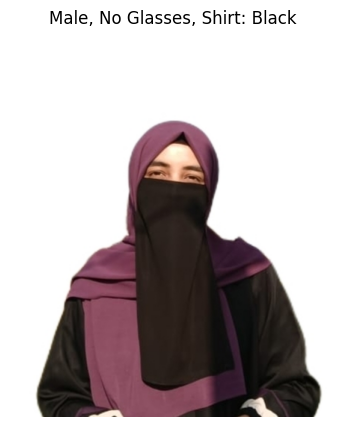

✅ Gender: Male
✅ Glasses: No Glasses
👕 Shirt Color: Black


In [8]:
model = MultiTaskResNet()
model.load_state_dict(torch.load("multitask_model.pth", map_location=torch.device("cpu")))
model.eval()

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

start = time.time()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load and transform image
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # shape: [1, 3, 224, 224]

# Predict
with torch.no_grad():
    gender_out, glasses_out = model(input_tensor)
print(f"Gender & Glasses Prediction Inference time: {(time.time() - start)*1000:.2f} ms")

gender_pred = torch.argmax(gender_out, dim=1).item()
glasses_pred = torch.argmax(glasses_out, dim=1).item()

gender_label = "Male" if gender_pred else "Female"
glasses_label = "With Glasses" if glasses_pred else "No Glasses"

#shirt color prediction
start1 = time.time()
cv_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
shirt_crop = crop_shirt_region(cv_img)
shirt_label = get_shirt_color(shirt_crop)
print(f"Shirt-Color Prediction Inference time: {(time.time() - start1)*1000:.2f} ms")

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis("off")
plt.title(f"{gender_label}, {glasses_label}, Shirt: {shirt_label}")
plt.show()

print("✅ Gender:", gender_label)
print("✅ Glasses:", glasses_label)
print("👕 Shirt Color:", shirt_label)
